# <center>CS 273A – MACHINE LEARNING PROJECT REPORT</center>
### <center>Prof. Sameer Singh</center>
<center>Team Members:</center>
<center>Yuyang Chen (ID: ​ 28604717​ )</center>
<center>Zhetai Shao (ID: 70963128)</center>
<center>Shi Zeng (ID: 36562594)</center>

In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import data_loader
%matplotlib inline

In [21]:
# Input

#     img_dir_path: directory path of 'images/'
#     label_file_path: label file path e.g. 'data/legend.csv'
#     valid_rate: validation data rate (0 - 1), 0.1 by default

# Output

#     train_file_paths: training image file path list
#     train_labels: training label array (numpy.ndarray)
#     valid_file_paths: validation image file path list
#     valid_labels: validation label array (numpy.ndarray)
#     test_file_paths: test image file path list
#     test_labels: test label array (numpy.ndarray)
#     label_dict: label dictionary (key: str, value: int)

train_file_paths,train_labels,valid_file_paths,valid_labels,test_file_paths,test_labels,label_dict=data_loader.load_dataset('images/', 'data/legend.csv', valid_rate=0.1)
idx = train_labels
train_labels = np.zeros((len(train_labels), len(label_dict)))
train_labels[np.arange(len(train_labels)), idx] = 1

idx = valid_labels
valid_labels = np.zeros((len(valid_labels), len(label_dict)))
valid_labels[np.arange(len(valid_labels)), idx] = 1

idx = test_labels
test_labels = np.zeros((len(test_labels), len(label_dict)))
test_labels[np.arange(len(test_labels)), idx] = 1

print(train_labels)
print(len(test_file_paths))

[[0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
1378


In [22]:
img_size = 32
batch_size = 200
num_classes = len(label_dict)
num_steps = 5000
display_step = 100
dropout = 0.75 # Dropout, probability to keep units
learning_rate = 1e-3

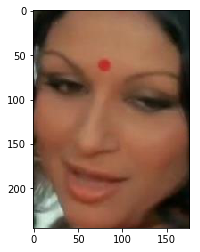

In [23]:
img = mpimg.imread(train_file_paths[0])
plt.imshow(img)
plt.show()


In [24]:
def preprocessing(filename, label):
    image_string = tf.read_file(filename)
    image_decode = tf.cond(
        tf.image.is_jpeg(image_string),
        lambda: tf.image.decode_jpeg(image_string, channels=1),
        lambda: tf.image.decode_png(image_string, channels=1))
    image_resize = tf.image.resize_images(image_decode, [img_size * img_size, 1])
    image = tf.squeeze(tf.cast(image_resize, tf.float32))
    return image, label

In [25]:
sess = tf.Session()

train_dataset = tf.data.Dataset.from_tensor_slices((train_file_paths, train_labels))
train_dataset = train_dataset.map(preprocessing)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(batch_size)


val_dataset = tf.data.Dataset.from_tensor_slices((valid_file_paths, valid_labels))
val_dataset = val_dataset.map(preprocessing)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(batch_size)


test_dataset = tf.data.Dataset.from_tensor_slices((test_file_paths, test_labels))
test_dataset = test_dataset.map(preprocessing)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(batch_size)



iterator1 = train_dataset.make_initializable_iterator()
iterator2 = val_dataset.make_initializable_iterator()
iterator3 = test_dataset.make_initializable_iterator()
sess.run(iterator1.initializer)
sess.run(iterator2.initializer)
sess.run(iterator3.initializer)
X_tr, Y_tr = iterator1.get_next()
X_val,Y_val = iterator2.get_next()
X_test,Y_test = iterator2.get_next()


In [26]:
weights = {'W_conv1': tf.Variable(tf.random_normal([5, 5, 1, 32])), 
            'W_conv2': tf.Variable(tf.random_normal([3, 3, 32, 64])),
            'W_conv3': tf.Variable(tf.random_normal([2, 2, 64, 128])), ##64 and 128 are arbitrary, doesn't have to be power of 2
            'W_fc1': tf.Variable(tf.random_normal([4*4*128, 1024])),
            'out': tf.Variable(tf.random_normal([1024, num_classes]))}
biases = {'b_conv1': tf.Variable(tf.random_normal([32])),
            'b_conv2': tf.Variable(tf.random_normal([64])),
            'b_conv3': tf.Variable(tf.random_normal([128])),
            'b_fc1': tf.Variable(tf.random_normal([1024])),
            'out': tf.Variable(tf.random_normal([num_classes]))}

saver = tf.train.Saver(max_to_keep=1)  # defaults to saving all variables - in this case w and b

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool2d(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding='SAME')

# def conv_neural_network_model(data):
#     x = tf.reshape(data, shape=[-1, 48, 48, 1])
#     conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1'] ##here, images are still 48*48
#     conv1 = maxpool2d(conv1) ##images now 24*24
#     conv2 = conv2d(conv1, weights['W_conv2']) + biases['b_conv2']
#     conv2 = maxpool2d(conv2) ##images now 12*12
#     conv3 = conv2d(conv2, weights['W_conv3']) + biases['b_conv3']
#     conv3 = maxpool2d(conv3) ##images now 6*6

#     fc1 = tf.reshape(conv3, [-1, 6*6*128])
#     fc1 = tf.nn.relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
#     fc1 = tf.nn.dropout(fc1, keep_rate)
#     #fc2 = tf.nn.relu(tf.matmul(fc1, weights['W_fc2'])+biases['b_fc2'])
#     #fc2 = tf.nn.dropout(fc2, keep_rate)	
#     output = tf.matmul(fc1, weights['out'])+biases['out']

#     return output

In [27]:
# Create model
def conv_net(x, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, img_size, img_size, 1])

        conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1'] ##here, images are still 32*32
        conv1 = maxpool2d(conv1) ##images now 16*16
        conv2 = conv2d(conv1, weights['W_conv2']) + biases['b_conv2']
        conv2 = maxpool2d(conv2) ##images now 8*8
        conv3 = conv2d(conv2, weights['W_conv3']) + biases['b_conv3']
        conv3 = maxpool2d(conv3) ##images now 4*4
        # Convolution Layer with 32 filters and a kernel size of 5
        # conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
       
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        # conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 32 filters and a kernel size of 5
       # conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        #conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        #fc1 = tf.contrib.layers.flatten(conv2)
        
        # Fully connected layer (in contrib folder for now)
        #fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        #fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
        fc1 = tf.reshape(conv3, [-1, 4*4*128])
        fc1 = tf.nn.relu(tf.matmul(fc1, weights['W_fc1'])+biases['b_fc1'])
        fc1 = tf.nn.dropout(fc1, dropout)
        # Output layer, class prediction
        #out = tf.layers.dense(fc1, n_classes)
        out = tf.matmul(fc1, weights['out'])+biases['out']
        # Because 'softmax_cross_entropy_with_logits' already apply softmax,
        # we only apply softmax to testing network
        out = tf.nn.softmax(out) if not is_training else out

    return out


# Create a graph for training
logits_train = conv_net(X_tr, num_classes, dropout, reuse=False, is_training=True)
# Create another graph for testing that reuse the same weights, but has
# different behavior for 'dropout' (not applied).
logits_val = conv_net(X_val, num_classes, dropout, reuse=True, is_training=False)
logits_test = conv_net(X_test, num_classes, dropout, reuse=True, is_training=False)

# Define loss and optimizer (with train logits, for dropout to take effect)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits_train, labels=Y_tr))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits_train, 1), tf.argmax(Y_tr, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Run the initializer
sess.run(init)

# Training cycle
for step in range(1, num_steps + 1):

    # Run optimization
    sess.run(train_op)

    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        # (note that this consume a new batch of data)
        loss, acc = sess.run([loss_op, accuracy])
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Optimization Finished!")

Step 1, Minibatch Loss= 110317504.0000, Training Accuracy= 0.260
Step 100, Minibatch Loss= 22731316.0000, Training Accuracy= 0.450
Step 200, Minibatch Loss= 13153101.0000, Training Accuracy= 0.425
Step 300, Minibatch Loss= 7019447.0000, Training Accuracy= 0.445
Step 400, Minibatch Loss= 3440978.5000, Training Accuracy= 0.450
Step 500, Minibatch Loss= 3782007.2500, Training Accuracy= 0.450
Step 600, Minibatch Loss= 1406716.1250, Training Accuracy= 0.460
Step 700, Minibatch Loss= 874813.1250, Training Accuracy= 0.405
Step 800, Minibatch Loss= 730703.6875, Training Accuracy= 0.285
Step 900, Minibatch Loss= 479580.4062, Training Accuracy= 0.475
Step 1000, Minibatch Loss= 240097.3125, Training Accuracy= 0.500
Step 1100, Minibatch Loss= 197024.0781, Training Accuracy= 0.510
Step 1200, Minibatch Loss= 102571.8828, Training Accuracy= 0.495
Step 1300, Minibatch Loss= 191641.8594, Training Accuracy= 0.445
Step 1400, Minibatch Loss= 178287.3594, Training Accuracy= 0.485
Step 1500, Minibatch Loss=

In [28]:
correct_pred = tf.equal(tf.argmax(logits_test, 1), tf.argmax(Y_test, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
acc = sess.run(accuracy)
print("Test Accuracy= "+"{:.3f}".format(acc))

Test Accuracy= 0.970


In [112]:
correct_pred = tf.equal(tf.argmax(logits_val, 1), tf.argmax(Y_val, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
acc = sess.run(accuracy)
print("Validation Accuracy= "+"{:.3f}".format(acc))

Validation Accuracy= 0.970


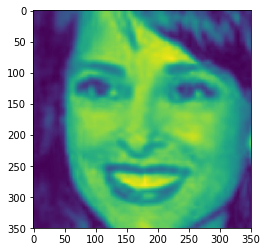

Tensor("ArgMax_44:0", shape=(8,), dtype=int64)
[0. 0. 0. 0. 0. 0. 0. 1.]
[0.02452009730041027, 0.5218103528022766, 0.013954563066363335, 0.016176870092749596, 0.01694643311202526, 0.001630108687095344, 0.003074406646192074, 0.4018871486186981]
2


In [115]:
img_idx = 1003

img = mpimg.imread(test_file_paths[img_idx])
plt.imshow(img)
plt.show()
img,label = preprocessing(test_file_paths[img_idx],test_labels[img_idx])


print(tf.argmax(logits_test))


classification = sess.run(logits_test)
prediction = sum(classification)
prediction = prediction/sum(prediction)
print(test_labels[img_idx])
prediction = prediction.tolist()
print(prediction)
print(prediction.index(max(prediction))+1)


